# RNN Model

## Data Import


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras_tuner as kt
from keras.layers import SimpleRNN, Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import normalize
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
)

In [2]:
df_train = pd.read_csv("dataset/output/no-oversampling/train.csv")
df_test = pd.read_csv("dataset/output/test.csv")

## Data Preparation


In [3]:
# split into X_train, y_train, X_test, y_test
X_train = df_train.drop(columns=["target"])
y_train = df_train["target"]
X_test = df_test.drop(columns=["target"])
y_test = df_test["target"]

# normalize data
X_train = normalize(X_train)
X_test = normalize(X_test)
y_train = normalize(y_train.values.reshape(-1, 1))
y_test = normalize(y_test.values.reshape(-1, 1))

## Helper Functions


In [4]:
# This plots the auc against iteration to detect overfitting
def plot_hist(hist, metric="accuracy"):
    plt.plot(hist.history[metric])
    plt.plot(hist.history["val_" + metric])
    plt.title(f"model performance")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return

## Model Building


### Base Model


In [5]:
def create_model():
    model = Sequential()
    model.add(
        SimpleRNN(
            units=128,
            input_shape=(X_train.shape[1], 1),
            activation='relu'
        )
    )
    model.add(Dense(32, activation='relu'))  # Additional Dense layer
    model.add(Dense(1))  # Final output layer
    model.compile(
        loss='mean_squared_error', 
        optimizer='adam', 
        metrics=['accuracy']
    )
    return model

In [6]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16640     
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20801 (81.25 KB)
Trainable params: 20801 (81.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test)
)

Epoch 1/100
281/281 [==============================] - 2s 3ms/step - loss: 0.2351 - accuracy: 0.6324 - val_loss: 0.2270 - val_accuracy: 0.6450
Epoch 2/100
281/281 [==============================] - 1s 2ms/step - loss: 0.2297 - accuracy: 0.6444 - val_loss: 0.2219 - val_accuracy: 0.6695
Epoch 3/100
281/281 [==============================] - 1s 2ms/step - loss: 0.2290 - accuracy: 0.6435 - val_loss: 0.2242 - val_accuracy: 0.6512
Epoch 4/100
281/281 [==============================] - 1s 2ms/step - loss: 0.2292 - accuracy: 0.6414 - val_loss: 0.2210 - val_accuracy: 0.6655
Epoch 5/100
281/281 [==============================] - 1s 2ms/step - loss: 0.2286 - accuracy: 0.6454 - val_loss: 0.2224 - val_accuracy: 0.6592
Epoch 6/100
281/281 [==============================] - 1s 2ms/step - loss: 0.2284 - accuracy: 0.6448 - val_loss: 0.2217 - val_accuracy: 0.6615
Epoch 7/100
281/281 [==============================] - 1s 2ms/step - loss: 0.2279 - accuracy: 0.6476 - val_loss: 0.2224 - val_accuracy: 0.6713

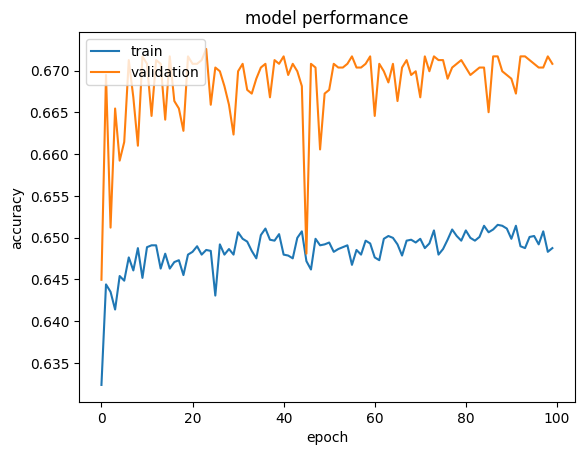

In [8]:
plot_hist(history)

In [9]:
# print confusion matrix and accuracy
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)  # Round predicted probabilities and convert to integers (0 or 1)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(y_test, y_pred))

71/71 [==============================] - 0s 1ms/step
Accuracy:  0.6708296164139161

Confusion Matrix: 
 [[1364   82]
 [ 656  140]]

classification_report: 
               precision    recall  f1-score   support

         0.0       0.68      0.94      0.79      1446
         1.0       0.63      0.18      0.28       796

    accuracy                           0.67      2242
   macro avg       0.65      0.56      0.53      2242
weighted avg       0.66      0.67      0.61      2242



### Tuned Model


In [10]:
def tune_model(hp):
    units = hp.Choice('units', [128, 256])
    dense_units = hp.Int("dense_units", min_value=16, max_value=64, step=16)
    activation = hp.Choice('activation', ['relu', 'sigmoid'])
    optimizer = hp.Choice('optimizer', ['adam', 'adagrad'])
    loss = hp.Choice('loss', ['binary_crossentropy', 'binary_focal_crossentropy'])

    model = Sequential()
    model.add(
        SimpleRNN(
            units=units,
            input_shape=(X_train.shape[1], 1),
            activation=activation
        )
    )
    model.add(Dense(dense_units, activation=activation))  # Additional Dense layer
    model.add(Dense(1))  # Final output layer
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

tuner = kt.GridSearch(
    tune_model,
    objective='accuracy',
    directory="tuned_models",
    project_name="thyroid_rnn_tuning"
)

tuner.search(
    X_train,
    y_train,
    epochs=30,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=5)]
)

Trial 64 Complete [00h 00m 13s]
accuracy: 0.622804582118988

Best accuracy So Far: 0.6458042860031128
Total elapsed time: 00h 11m 42s
INFO:tensorflow:Oracle triggered exit


In [11]:
import pprint
best_hp = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_model = tuner.hypermodel.build(best_hp)
print("best hyperparameters:\n", pprint.pformat(best_hp.values))
best_model.summary()

best hyperparameters:
 {'activation': 'relu',
 'dense_units': 48,
 'loss': 'binary_focal_crossentropy',
 'optimizer': 'adam',
 'units': 256}
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 256)               66048     
                                                                 
 dense_2 (Dense)             (None, 48)                12336     
                                                                 
 dense_3 (Dense)             (None, 1)                 49        
                                                                 
Total params: 78433 (306.38 KB)
Trainable params: 78433 (306.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
history = best_model.fit(
    X_train,
    y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_test, y_test),
)

Epoch 1/100
281/281 [==============================] - 2s 5ms/step - loss: 0.1782 - accuracy: 0.6264 - val_loss: 0.1611 - val_accuracy: 0.6588
Epoch 2/100
281/281 [==============================] - 1s 4ms/step - loss: 0.1647 - accuracy: 0.6432 - val_loss: 0.1609 - val_accuracy: 0.6557
Epoch 3/100
281/281 [==============================] - 1s 4ms/step - loss: 0.1641 - accuracy: 0.6431 - val_loss: 0.1628 - val_accuracy: 0.6588
Epoch 4/100
281/281 [==============================] - 1s 4ms/step - loss: 0.1639 - accuracy: 0.6456 - val_loss: 0.1610 - val_accuracy: 0.6704
Epoch 5/100
281/281 [==============================] - 1s 4ms/step - loss: 0.1637 - accuracy: 0.6452 - val_loss: 0.1602 - val_accuracy: 0.6717
Epoch 6/100
281/281 [==============================] - 1s 4ms/step - loss: 0.1637 - accuracy: 0.6438 - val_loss: 0.1634 - val_accuracy: 0.6450
Epoch 7/100
281/281 [==============================] - 1s 4ms/step - loss: 0.1640 - accuracy: 0.6463 - val_loss: 0.1604 - val_accuracy: 0.6650

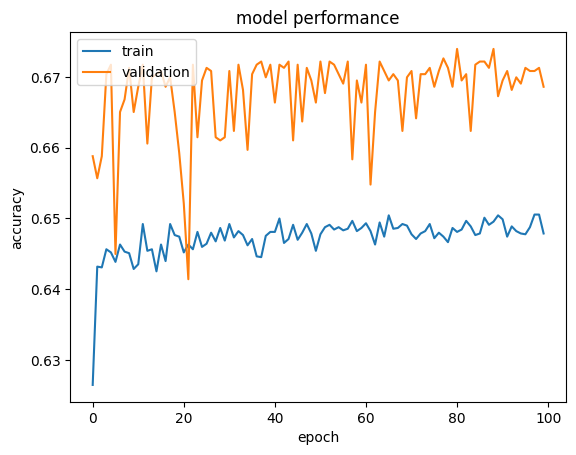

In [13]:
plot_hist(history)

In [14]:
# print confusion matrix and accuracy
y_pred = best_model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(y_test, y_pred))

71/71 [==============================] - 0s 2ms/step
Accuracy:  0.6685994647636039

Confusion Matrix: 
 [[1374   72]
 [ 671  125]]

classification_report: 
               precision    recall  f1-score   support

         0.0       0.67      0.95      0.79      1446
         1.0       0.63      0.16      0.25       796

    accuracy                           0.67      2242
   macro avg       0.65      0.55      0.52      2242
weighted avg       0.66      0.67      0.60      2242

